last version with right number of exposure for the whole LSST survey (https://arxiv.org/pdf/0805.2366.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl
from tensorflow.keras import backend as K


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils, boxplot, layers

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

# Loading the trained VAE

In [59]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_2/v1/bis_bis_bis/mse/',6, folder= True) 

W0408 09:50:41.587858 139945237321536 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W0408 09:50:41.589116 139945237321536 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W0408 09:50:41.589917 139945237321536 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W0408 09:50:41.590714 139945237321536 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W0408 09:50:41.591433 139945237321536 util.py:148] Unused attribute in object (root).layer_with_weights-1: ['OBJECT_CONFIG_JSON']
W0408 09:50:41.592184 139945237321536 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-0: ['OBJECT_CONFIG_JSON']
W0408 09:50:41.592902 139945237321536 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-1: ['OBJECT_CONFIG_JSON']
W0408 09:50:41.593617 139945237321536 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weig

In [23]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v_2/v1/bis_bis/mse/',10, folder = True)

W0331 19:04:12.368795 140211007321920 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W0331 19:04:12.370171 140211007321920 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W0331 19:04:12.371124 140211007321920 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W0331 19:04:12.372061 140211007321920 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W0331 19:04:12.372925 140211007321920 util.py:148] Unused attribute in object (root).layer_with_weights-1: ['OBJECT_CONFIG_JSON']
W0331 19:04:12.373824 140211007321920 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-0: ['OBJECT_CONFIG_JSON']
W0331 19:04:12.374894 140211007321920 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer-1: ['OBJECT_CONFIG_JSON']
W0331 19:04:12.375729 140211007321920 util.py:148] Unused attribute in object (root).layer_with_weights-0.layer_with_weig

# Load data

In [3]:
data_dir = "/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/centered/test/"
root = 'galaxies_isolated_20191024'

In [4]:
images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [5]:
test_sample = [data_dir+'galaxies_isolated_20191024_0_images.npy']

In [6]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [7]:
df['e_in']= np.sqrt(df['e1']**2+df['e2']**2)

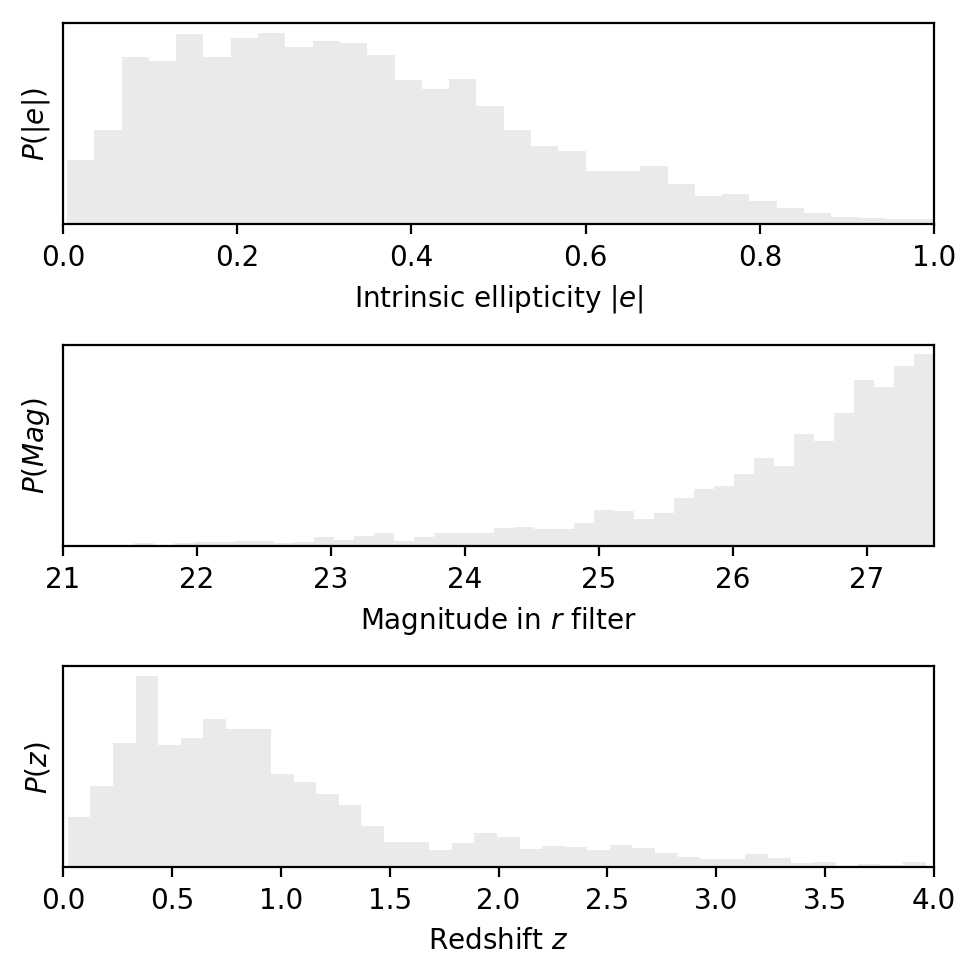

In [9]:
import matplotlib as mpl
mpl.rcdefaults()


fig, axes = plt.subplots(3, 1, figsize=(5,5), gridspec_kw={'height_ratios': [1,1,1]})

xlim = (0,1.)
sns.distplot(df['e_in'], ax=axes[0], color='0.8', kde = False)
axes[0].set_xlim(xlim[0], xlim[1])
axes[0].set_ylabel('$P(|e|$)', fontsize = 10)
axes[0].set_yticks([])
axes[0].set_xlabel('Intrinsic ellipticity $|e|$')

xlim = (21,27.5)
sns.distplot(df['mag'], ax=axes[1], color='0.8', kde = False)
axes[1].set_xlim(xlim[0], xlim[1])
axes[1].set_ylabel('$P(Mag)$', fontsize = 10)
axes[1].set_yticks([])
axes[1].set_xlabel('Magnitude in $r$ filter')

xlim = (0,4)
sns.distplot(df['redshift'], ax=axes[2], color='0.8', kde = False)
axes[2].set_xlim(xlim[0], xlim[1])
axes[2].set_ylabel('$P(z)$', fontsize = 10)
axes[2].set_yticks([])
axes[2].set_xlabel('Redshift $z$')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.6)

fig.savefig('figures_v2/param_distrib_2.pdf', dpi = 300)

# Parameters to fix

In [9]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

bands_r = [6]
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

In [10]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

## LSST all filters

In [ ]:
data_dir = "/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/centered/test/"
root = 'galaxies_isolated_20191024'

images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')
test_sample = [data_dir+'galaxies_isolated_20191024_0_images.npy']

In [62]:
df_lsst = results_processing.processing(vae_lsst_conv,
                                         data_dir,                                           
                                         root,
                                         test_sample[0],
                                         bands_lsst,
                                         2,
                                         stamp_size, 
                                         batch_size,
                                         PSF, 
                                         pix_scale_lsst,
                                         cut_mag = 27.5)


(10000, 2, 2)


In [18]:
df_lsst.to_csv('data_v2/df_vae_centered_lsst_symetric.csv')

In [91]:
df_lsst.to_csv('data_v2/df_vae_centered_lsst_2.csv')

In [8]:
df_lsst = pd.read_csv('data_v2/df_vae_centered_lsst_2.csv', encoding = 'utf-8')

### Shape plots

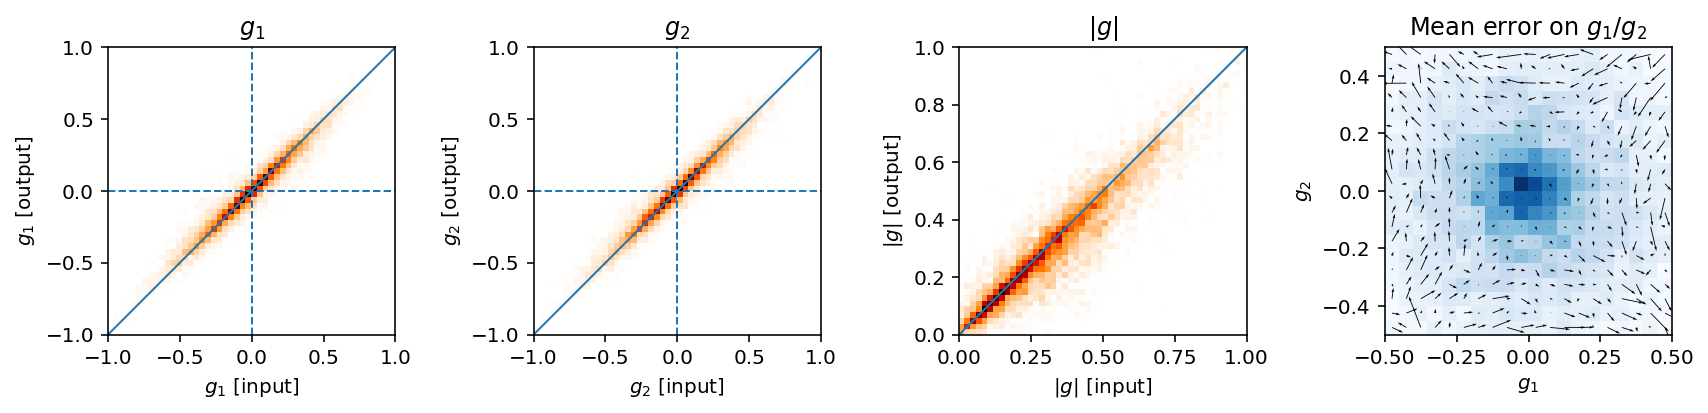

In [13]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst['e1_in'], df_lsst['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst['e2_in'], df_lsst['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst['e_in'], df_lsst['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,21)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst['e1_in'], df_lsst['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()
#plt.savefig('figures/ellipticities_lsst.pdf', dpi = 300)

|$g_1$|

In [15]:
# Linear regression
slope_lsst_1, intercept_lsst_1, r_value_lsst_1, p_value_lsst_1, std_err_lsst_1 = stats.linregress(df_lsst['e1_in'], df_lsst['e1_out'])

In [16]:
slope_lsst_1, intercept_lsst_1, r_value_lsst_1, p_value_lsst_1, std_err_lsst_1

(0.9301663811132678,
 -0.0029277902400705047,
 0.9658403654509068,
 0.0,
 0.0024959130555714582)

|$g_2$|

In [17]:
# Linear regression
slope_lsst_2, intercept_lsst_2, r_value_lsst_2, p_value_lsst_2, std_err_lsst_2 = stats.linregress(df_lsst['e2_in'], df_lsst['e2_out'])

In [18]:
slope_lsst_2, intercept_lsst_2, r_value_lsst_2, p_value_lsst_2, std_err_lsst_2

(0.9202590646099876,
 0.00030028498991291927,
 0.9631593923577064,
 0.0,
 0.0025697835643392025)

|g|

In [19]:
# Linear regression
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst = stats.linregress(df_lsst['e_in'], df_lsst['e_out'])

In [20]:
slope_lsst, intercept_lsst, r_value_lsst, p_value_lsst, std_err_lsst

(0.8938083754092488,
 0.021994171490930137,
 0.9297593870951181,
 0.0,
 0.003539671908389502)

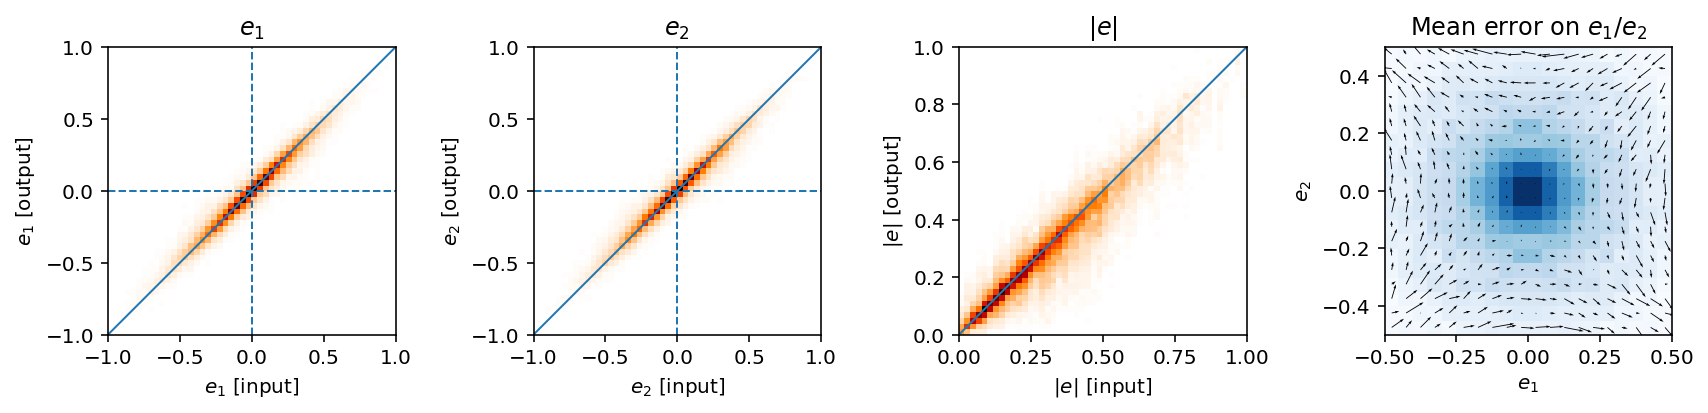

In [19]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst['e1_in'], df_lsst['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_1$ [input]')
ax.set_ylabel('$e_1$ [output]')
ax.set_title('$e_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst['e2_in'], df_lsst['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$e_2$ [input]')
ax.set_ylabel('$e_2$ [output]')
ax.set_title('$e_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst['e_in'], df_lsst['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|e|$ [input]')
ax.set_ylabel('$|e|$ [output]')
ax.set_title('$|e|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,21)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst['e1_in'], df_lsst['e2_in'], values=df_lsst['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst['e1_in'], df_lsst['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$e_1$')
ax.set_ylabel('$e_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $e_1/e_2$')

plt.tight_layout()
plt.savefig('figures_v2/ellipticities_lsst_symmetric.pdf', dpi = 300)

Text(0.5, 1.0, '$r$-band magnitude')

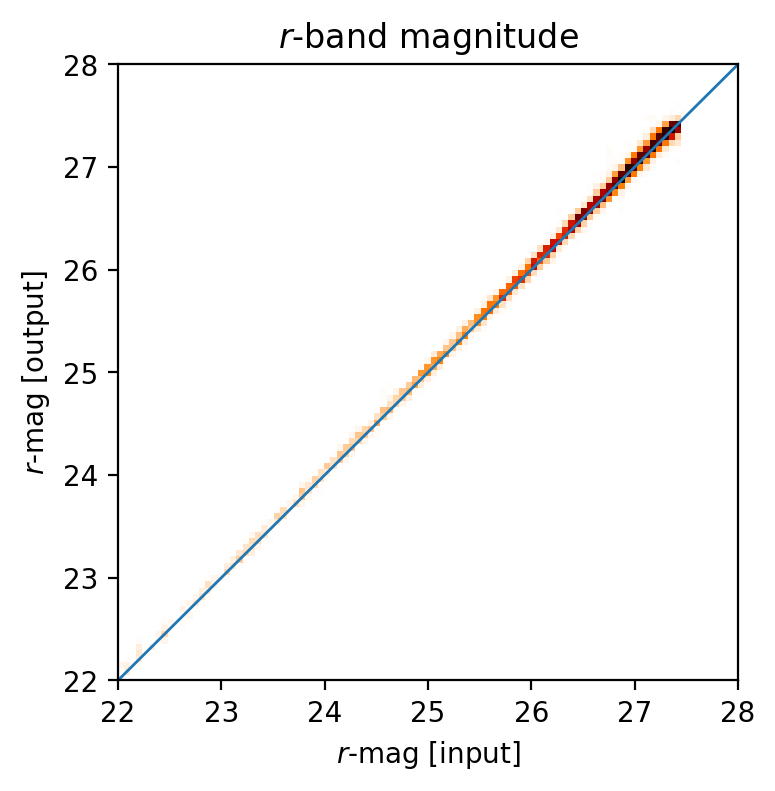

In [21]:
fig = plt.figure(figsize=(4,4))

emax = 100
bins = np.linspace(22,28,100)

#ax = fig.add_subplot(141, aspect='equal')
_ = plt.hist2d(df_lsst['mag_in'], df_lsst['mag_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax], lw=1)
plt.axhline(y=0, ls='--', lw=1)
plt.axvline(x=0, ls='--', lw=1)
plt.xlabel('$r$-mag [input]')
plt.ylabel('$r$-mag [output]')
plt.title('$r$-band magnitude')

#plt.tight_layout()


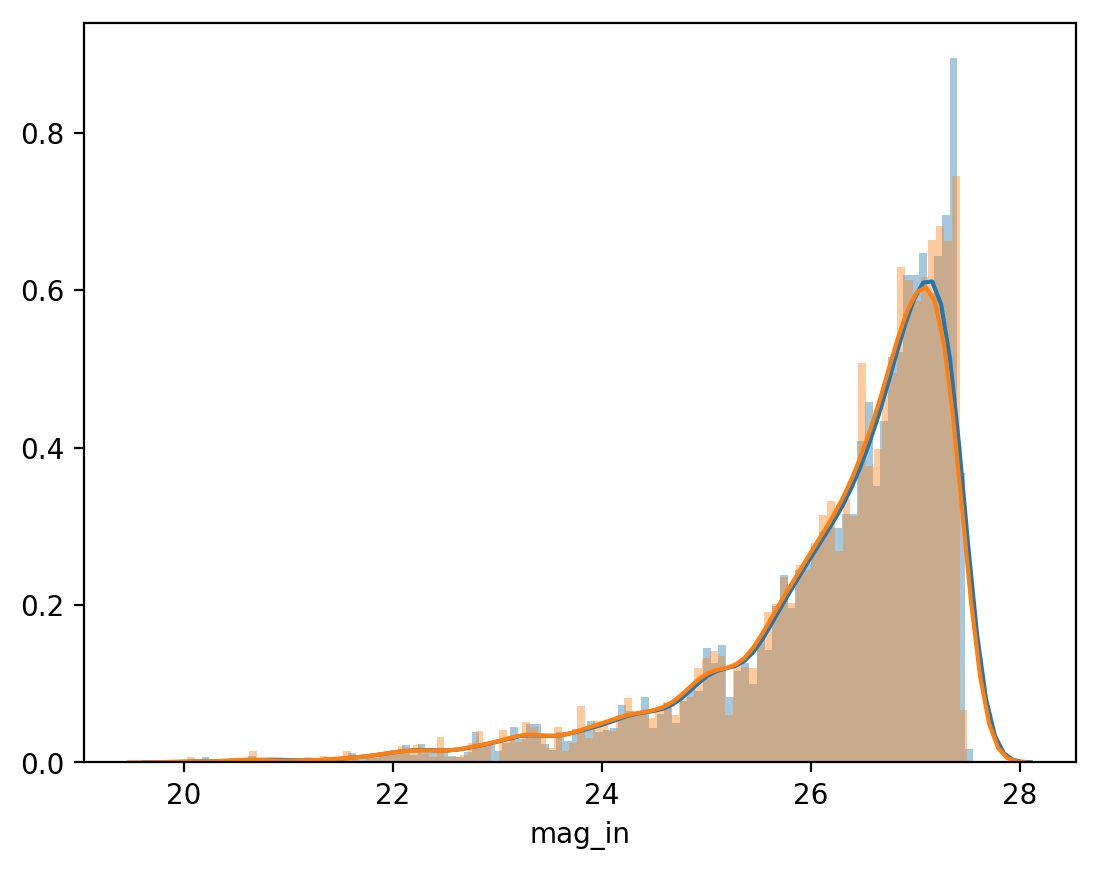

In [69]:
sns.distplot(df_lsst['mag_out'], bins = 100)
sns.distplot(df_lsst['mag_in'], bins = 100)

In [18]:
np.max(df_lsst['mag_out']), np.max(df_lsst['mag_in'])

(27.54668, 27.5)

In [14]:
batch_size = 100

a = utils.norm(images[:100,1,4:].transpose([0,2,3,1]), bands_lsst, data_dir, channel_last = True)
output_enc = encoder_LSST.predict(a, batch_size = batch_size)

latent_dim =32
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [15]:
z = []
#a = images[:100,1,4:].transpose([0,2,3,1])

for i in range (100):
    output_encoder = encoder_LSST.predict(a, batch_size = batch_size)
    z.append(sampling(output_enc))
    #z_i, Dkl = layers.SampleMultivariateGaussian(full_cov=False, add_KL=False, return_KL=True, coeff_KL=0)(output_encoder)
    #z.append(K.get_value(z_i))

z = np.concatenate(z, axis = 0)

In [33]:
z.shape

(10000, 32)

In [17]:
reload(plot)

<module 'tools_for_VAE.plot' from '../../scripts/tools_for_VAE/tools_for_VAE/plot.py'>

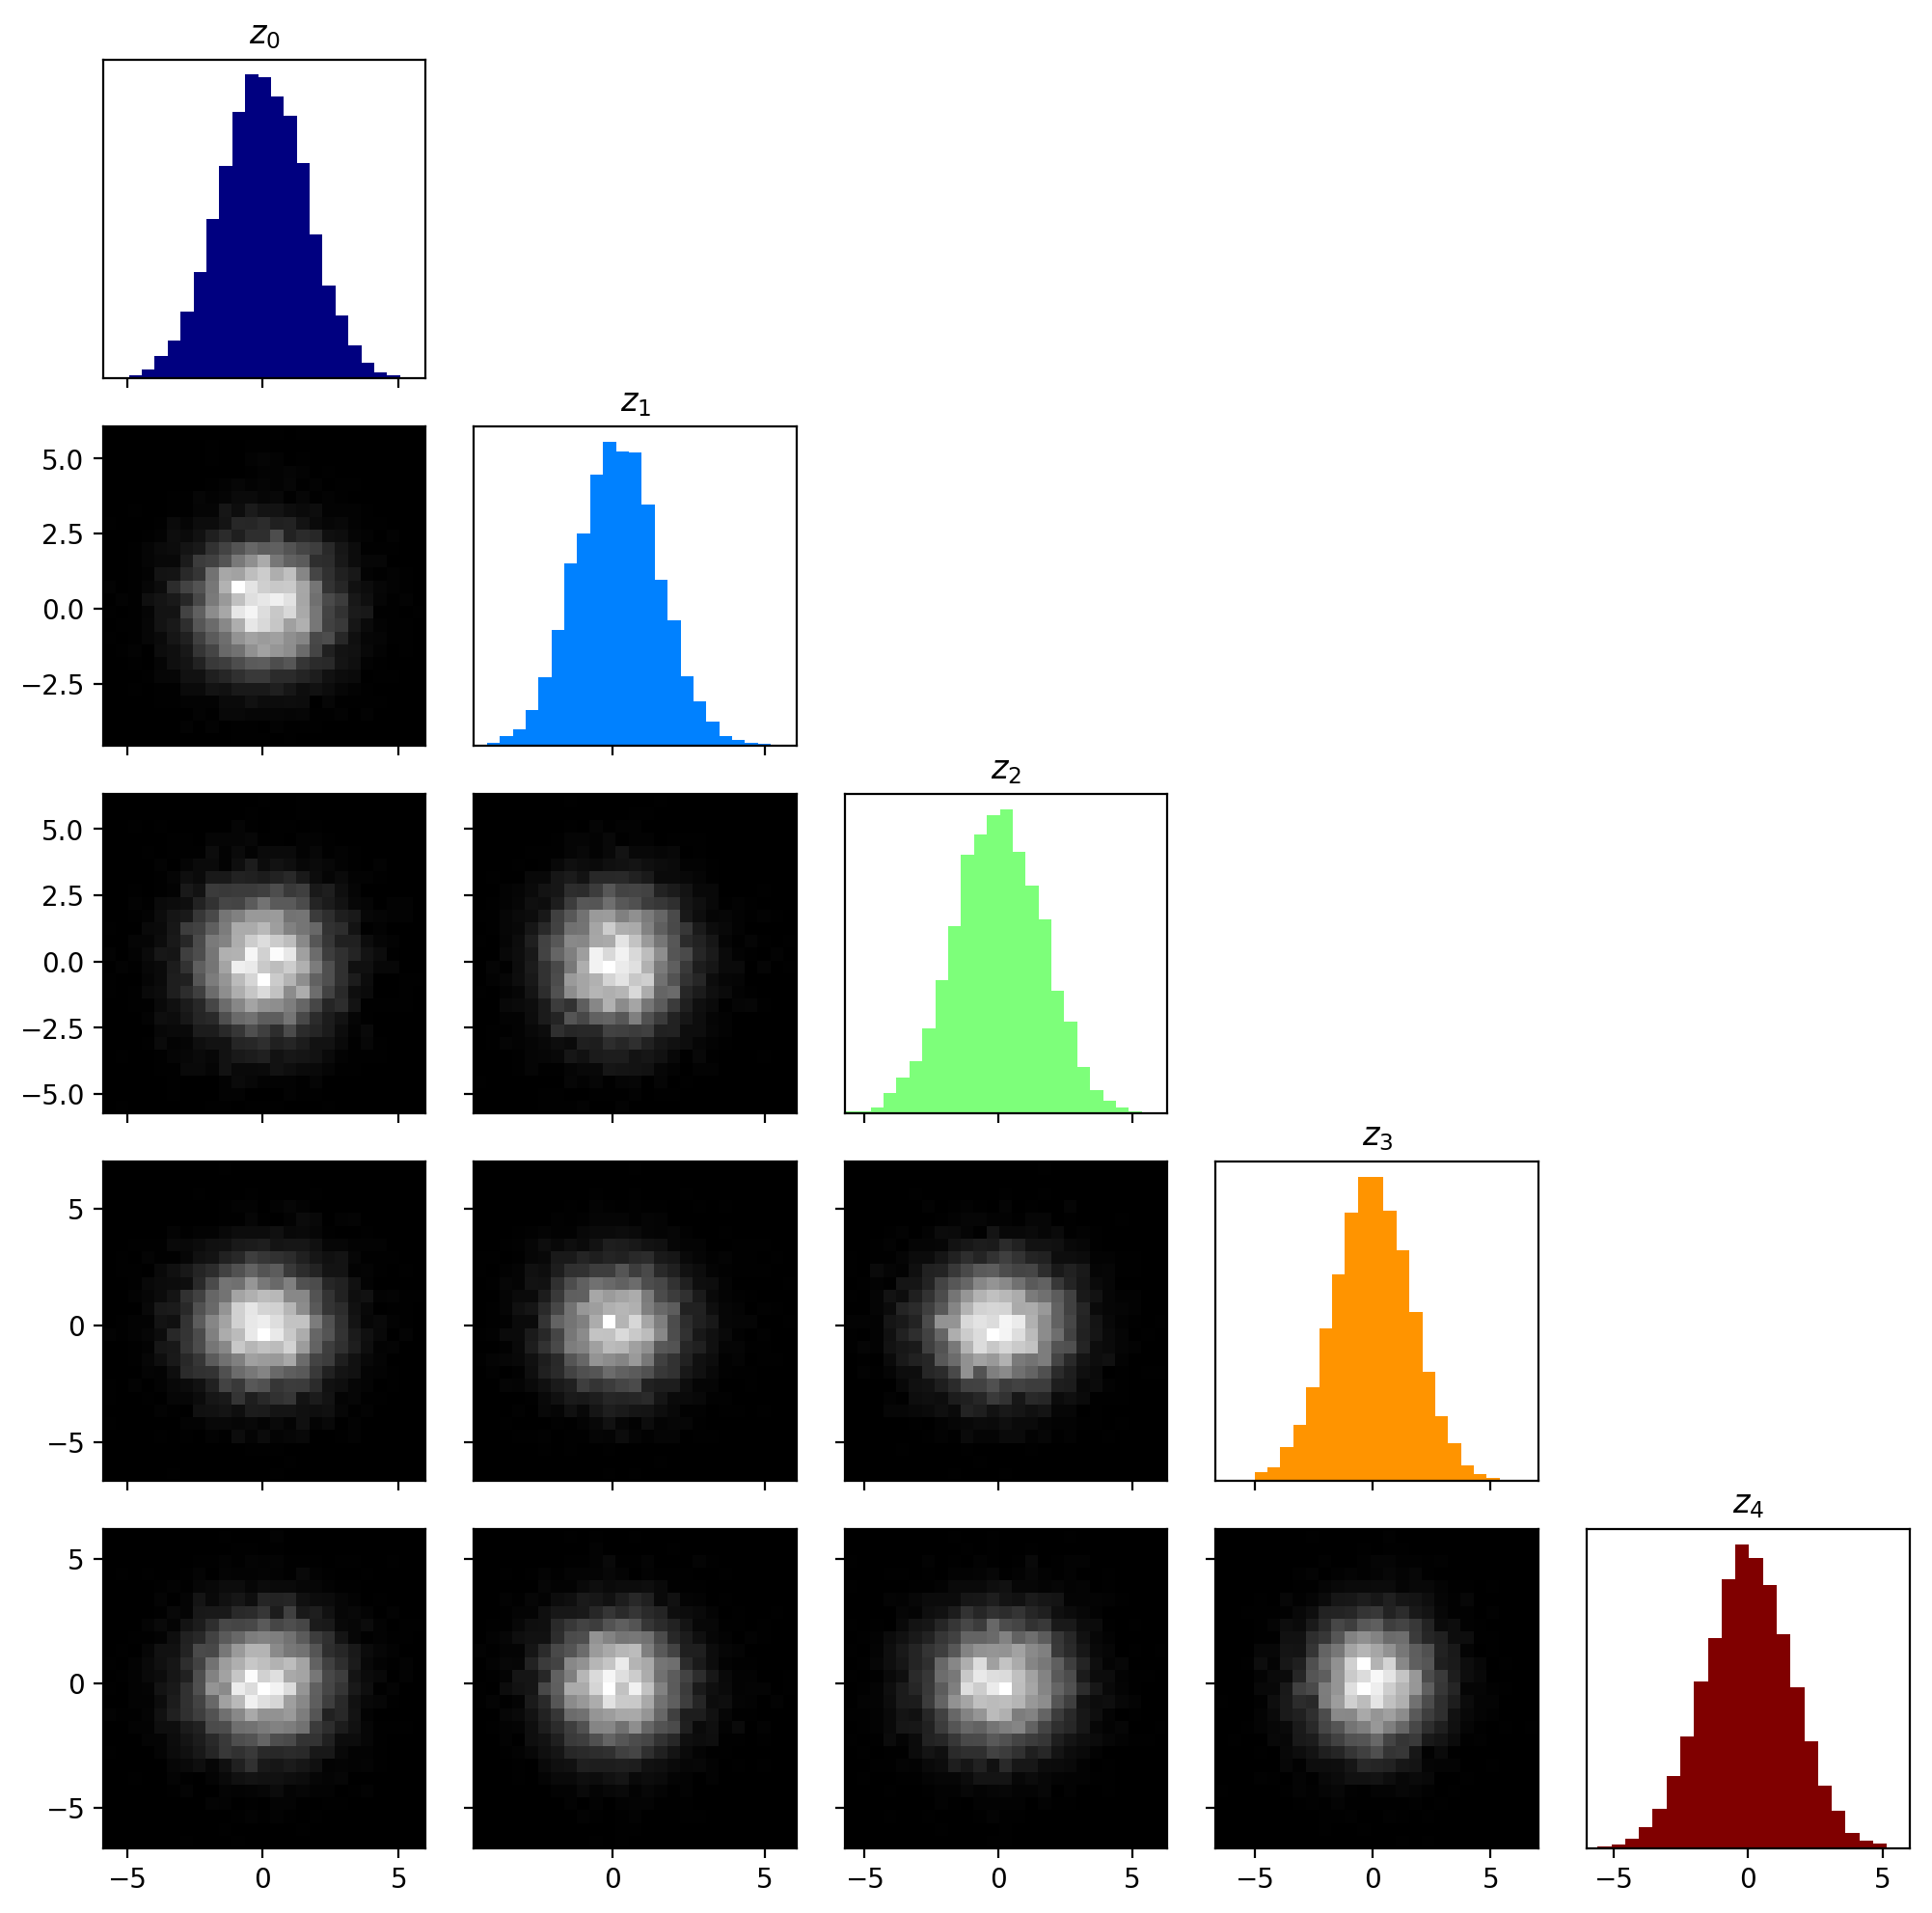

In [20]:
plot.plot_corner_latent(z[:,:5],lim = 6)
plt.savefig('figures_v2/corner_latent.pdf', dpi = 300)

In [35]:
plot_corner_latent(z)

## LSST + Euclid all filters

Test VAE_processing for LSST and Euclid all band-pass filters

In [ ]:
data_dir = "/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/centered_2/test/"
root = 'galaxies_isolated_20191024'

images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

test_sample = [data_dir+'galaxies_isolated_20191024_0_images.npy']

In [47]:
df_lsst_euclid = results_processing.processing(vae_lsst_euclid_conv,
                                                         data_dir,
                                                         root,
                                                         test_sample[0],
                                                         bands_lsst_euclid,
                                                         6,
                                                         stamp_size,
                                                         batch_size,
                                                         PSF, 
                                                         pix_scale_lsst,
                                                         cut_mag = 27.5)


(10000, 2, 2)


In [62]:
df_lsst_euclid.to_csv('data_v2/df_vae_lsst_euclid_symetric.csv')

In [48]:
df_lsst_euclid.to_csv('data_v2/df_vae_lsst_euclid.csv')

In [11]:
df_lsst_euclid = pd.read_csv('data_v2/df_vae_lsst_euclid.csv', encoding = 'utf-8')

### Shape plots

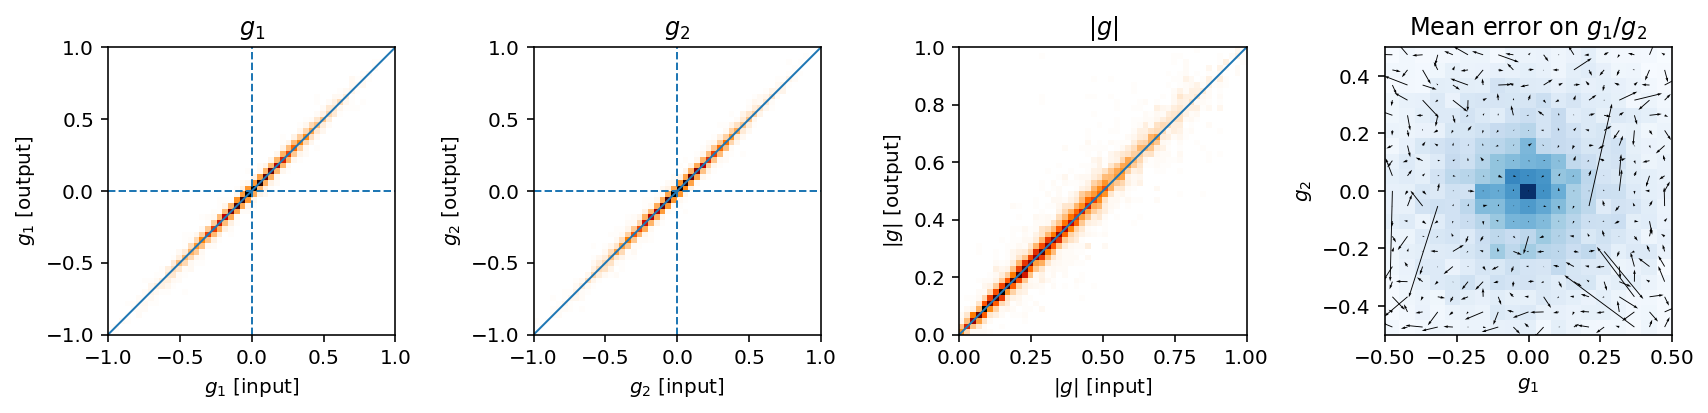

In [17]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))



# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

|$g_1$|

In [41]:
mask = ~np.isnan(df_lsst_euclid['e1_in']) & ~np.isnan(df_lsst_euclid['e1_out']) & ~(df_lsst_euclid['e1_in']>1)
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(df_lsst_euclid['e1_in'][mask], df_lsst_euclid['e1_out'][mask])

In [42]:
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid

(1.006865937503621,
 0.0007663991564284107,
 0.9864911512237204,
 0.0,
 0.0016733186676188543)

|$g_2$|

In [43]:
mask = ~np.isnan(df_lsst_euclid['e2_in']) & ~np.isnan(df_lsst_euclid['e2_out'])
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(df_lsst_euclid['e2_in'][mask], df_lsst_euclid['e2_out'][mask])

In [44]:
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid

(1.000916413170704,
 -0.0007678178544558413,
 0.9931037487554001,
 0.0,
 0.0011819660648173347)

|g|

In [45]:
mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid = stats.linregress(df_lsst_euclid['e_in'][mask], df_lsst_euclid['e_out'][mask])

In [46]:
slope_lsst_euclid, intercept_lsst_euclid, r_value_lsst_euclid, p_value_lsst_euclid, std_err_lsst_euclid

(0.9993252372765256,
 0.002717846368791188,
 0.9681536878409043,
 0.0,
 0.0025849488672435475)

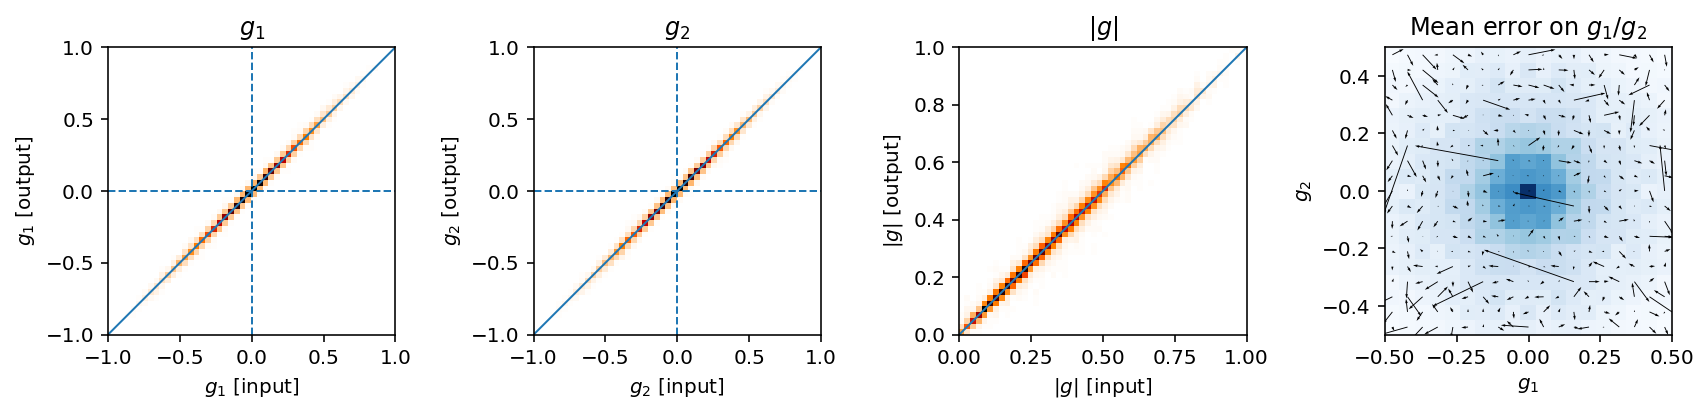

In [63]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))



# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

Text(0.5, 1.0, '$r$-band magnitude')

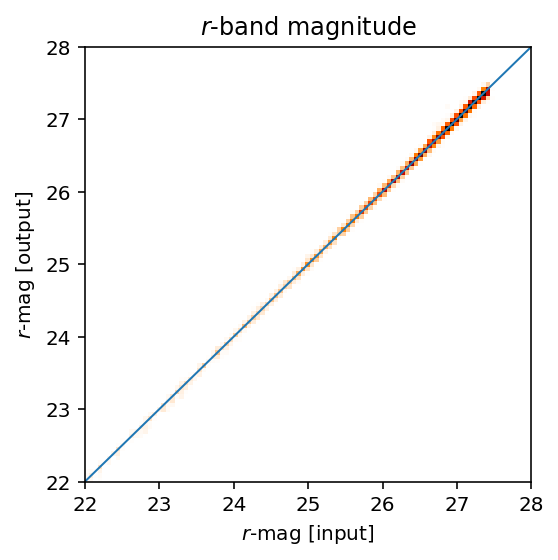

In [22]:
fig = plt.figure(figsize=(4,4))

emax = 100
bins = np.linspace(22,28,100)

#ax = fig.add_subplot(141, aspect='equal')
_ = plt.hist2d(df_lsst_euclid['mag_in'], df_lsst_euclid['mag_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax], lw=1)
plt.axhline(y=0, ls='--', lw=1)
plt.axvline(x=0, ls='--', lw=1)
plt.xlabel('$r$-mag [input]')
plt.ylabel('$r$-mag [output]')
plt.title('$r$-band magnitude')

#plt.tight_layout()


# Delta WL parameters

## As function of SNR

In [12]:
df_plot = pd.concat([df_lsst, df_lsst_euclid], ignore_index=True, sort = True)
df_plot['exp'] = [1]*10000 + [2]*10000

In [13]:
#df_plot = df_plot.drop('Unnamed: 0', axis = 1)

In [14]:
df_plot = df_plot.dropna(axis = 1, how = 'all')

df_plot = df_plot[(df_plot['e1_out']<=1.) & 
                  (df_plot['e2_out']<=1.) &
                  (df_plot['e1_out']>=-1.) & 
                  (df_plot['e2_out']>=-1.) &
                  (df_plot['e_out']>=0.) & 
                  (df_plot['e_out']<=1.) &
                  (df_plot['mag_out']<=27.5)]

In [15]:
df_plot

,SNR,SNR_peak,Unnamed: 0,delta_mag,e1,e1_error,e1_in,e1_out,e2,e2_error,...,idx_closest_to_peak,mag,mag_in,mag_ir,mag_out,moment_sigma,n_peak_detected,nb_blended_gal,redshift,exp
0,39.422313,0.049475,0,-0.020820,-0.372082,-0.006285,-0.372082,-0.378367,0.177890,-0.074204,...,0,27.009990,26.935112,-1.171130,26.914291,1.690560,1,1,0.8545,1
1,151.416548,0.157856,1,-0.025192,-0.187576,0.010051,-0.187576,-0.177525,-0.375145,-0.026216,...,0,25.261316,25.186388,-2.491817,25.161196,2.203068,1,1,0.7886,1
2,285.744421,0.356327,2,-0.060010,-0.066240,-0.006622,-0.066240,-0.072862,0.182918,0.018101,...,0,24.205848,24.181287,-4.277390,24.121277,1.999021,1,1,0.5207,1
3,54.579881,0.036141,3,-0.018245,-0.044676,0.021910,-0.044676,-0.022766,-0.042812,-0.011956,...,0,25.578211,25.504207,-3.088042,25.485962,4.178689,1,1,1.2278,1
4,26.613761,0.024508,4,-0.033449,0.101232,0.025313,0.101232,0.126546,-0.483622,-0.178802,...,0,27.013882,26.938971,-0.083410,26.905521,2.491038,1,1,0.4857,1
6,35.211904,0.041161,6,0.057183,0.296705,-0.000854,0.296705,0.295851,-0.066968,-0.088633,...,0,27.089047,27.014099,-1.122494,27.071281,1.808647,1,1,1.2307,1
7,20.478632,0.021481,7,0.007018,-0.152243,-0.052438,-0.152243,-0.204681,-0.163014,0.108298,...,0,27.270513,27.207639,-2.497474,27.214657,2.189180,1,1,1.1121,1
8,828.732001,0.763217,8,0.036911,-0.329148,-0.003702,-0.329148,-0.332851,0.112816,0.003847,...,0,22.839363,22.764496,-3.853695,22.801407,3.074658,1,1,0.1109,1
9,22.610563,0.025584,9,-0.050342,0.280389,-0.053417,0.280389,0.226973,-0.074379,-0.181388,...,0,27.488520,27.413589,0.317223,27.363247,1.909637,1,1,0.5204,1
10,19.747941,0.019188,10,0.004428,-0.023540,-0.055507,-0.023540,-0.079047,-0.215599,-0.013363,...,0,27.330053,27.256368,-1.789576,27.260796,2.401456,1,1,1.1467,1


In [16]:
df_plot = df_plot.drop('Unnamed: 0', axis = 1)

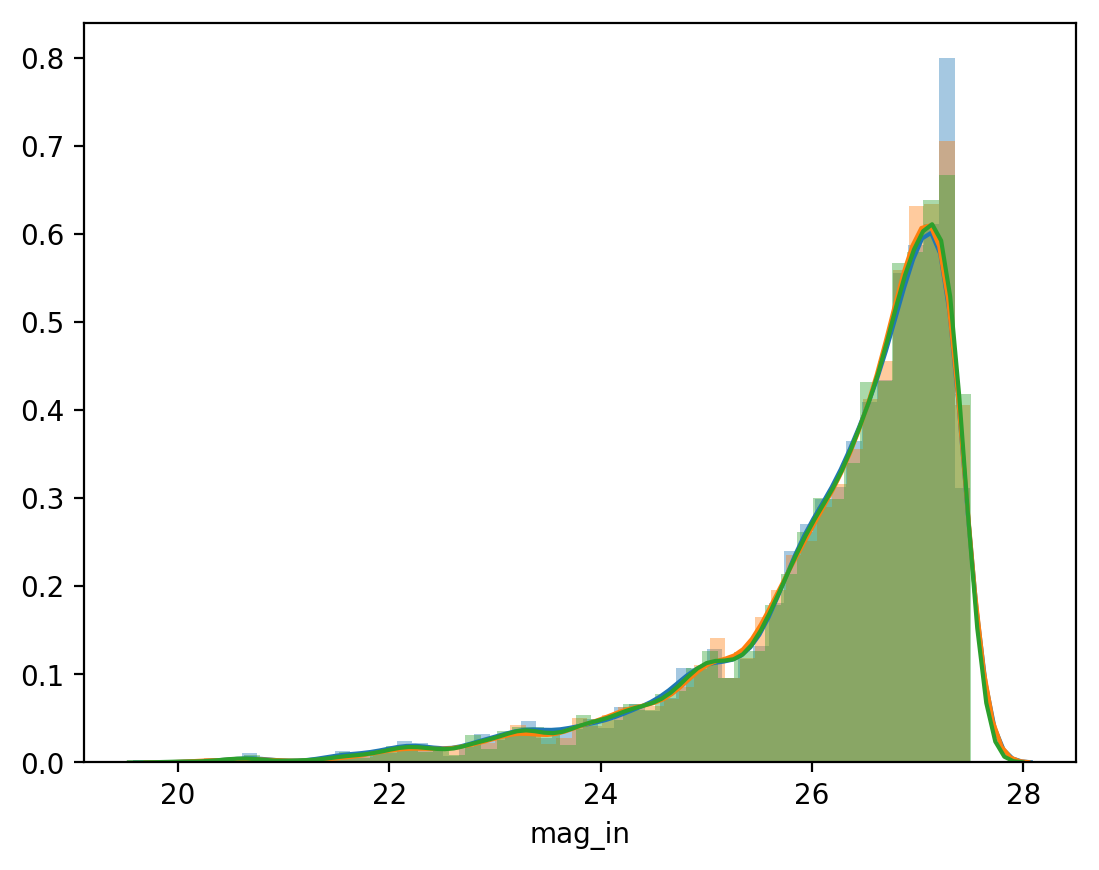

In [99]:
sns.distplot(df_plot['mag_out'][0:10000])
sns.distplot(df_plot['mag_out'][10000:])
sns.distplot(df_plot['mag_in'])

19811
[1 2]
0 1
1 2


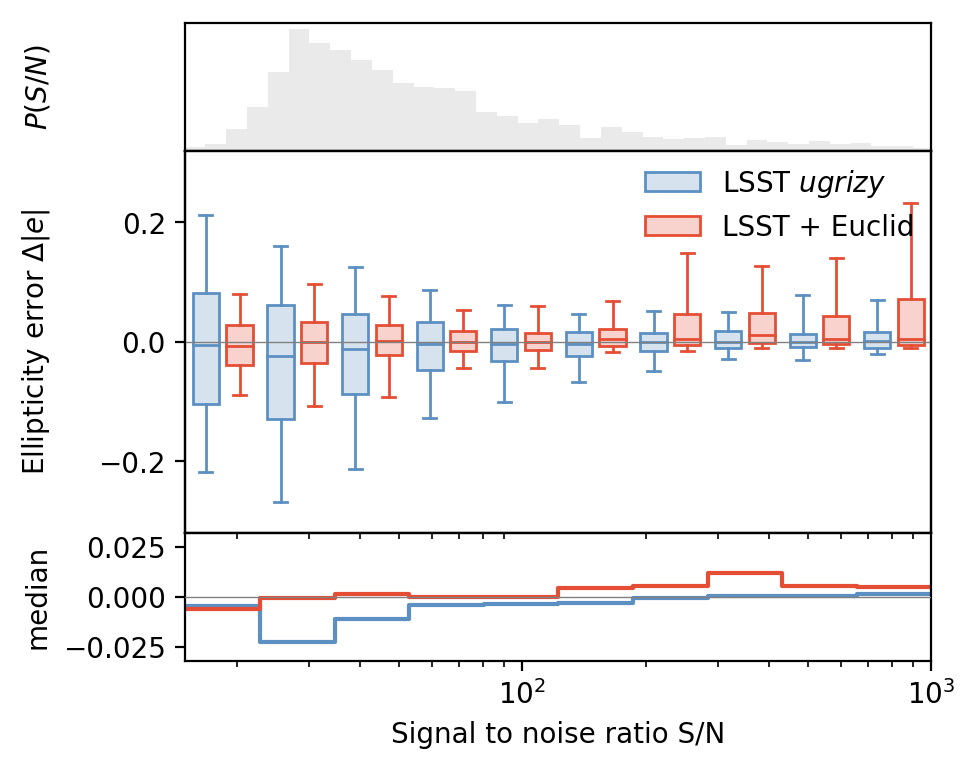

In [17]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (15, 1000),
              ylim = (-0.32, 0.32), 
              ylim2 = (-0.032, 0.032), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

19811
[1 2]
0 1
1 2


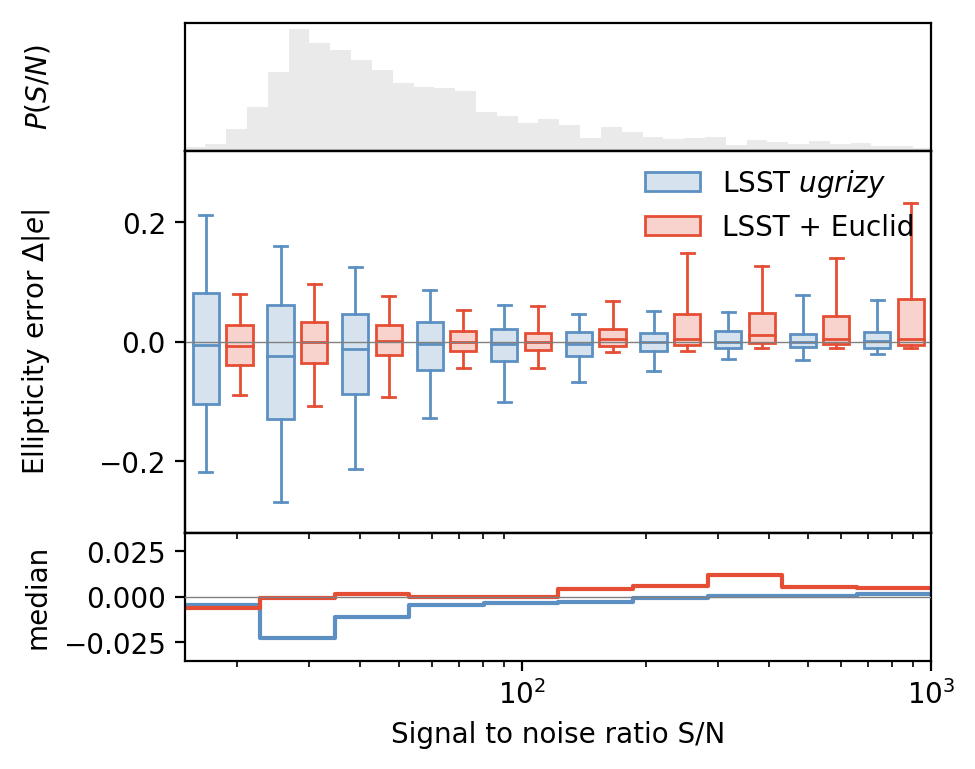

In [47]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (15, 1000),
              ylim = (-0.32, 0.32), 
              ylim2 = (-0.035, 0.035), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)
fig.savefig('figures_v2/e_vae_snr_3.pdf')

old plots

19817
[1 2]
0 1
1 2


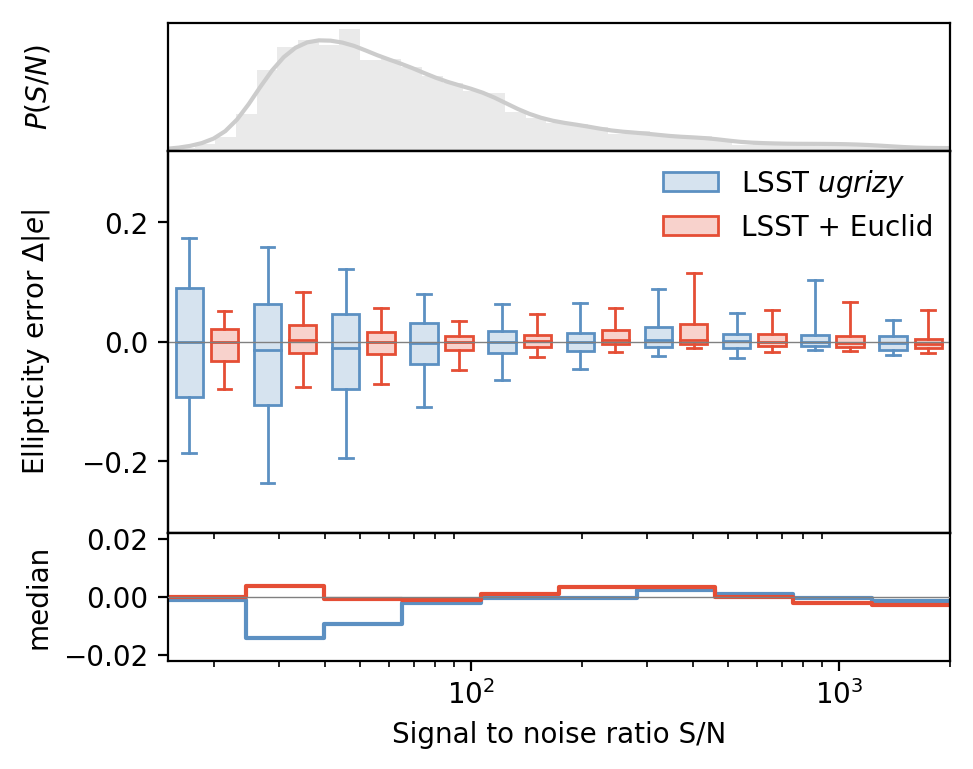

In [16]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (15, 2000),
              ylim = (-0.32, 0.32), 
              ylim2 = (-0.022, 0.022), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Ellipticity error $\\Delta |e|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)


#fig.savefig('figures/e_vae_snr_3.pdf')

19811
[1 2]
0 1
1 2


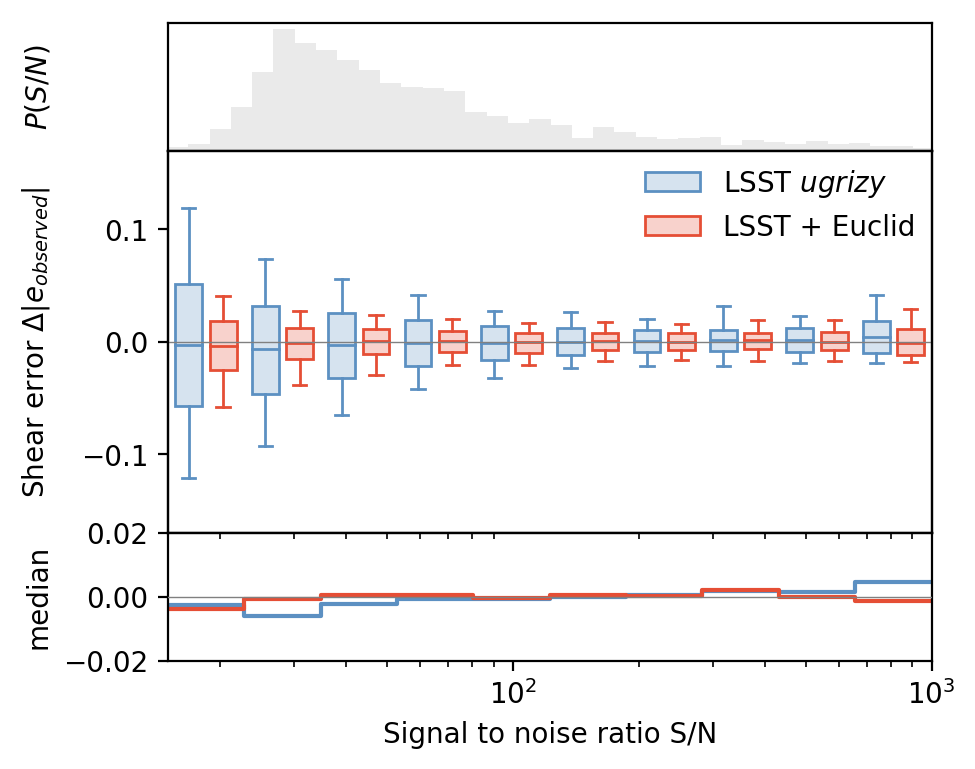

In [19]:
fig, median_shear_2, q1_shear_2, q3_shear_2, whislo_shear_2, whishi_shear_2 = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_obs_error', z = 'exp',
              xlim = (15, 1000),
              ylim = (-0.17, 0.17), 
              ylim2 = (-0.02, 0.02), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |e_{observed}|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

old plot

19817
[1 2]
0 1
1 2


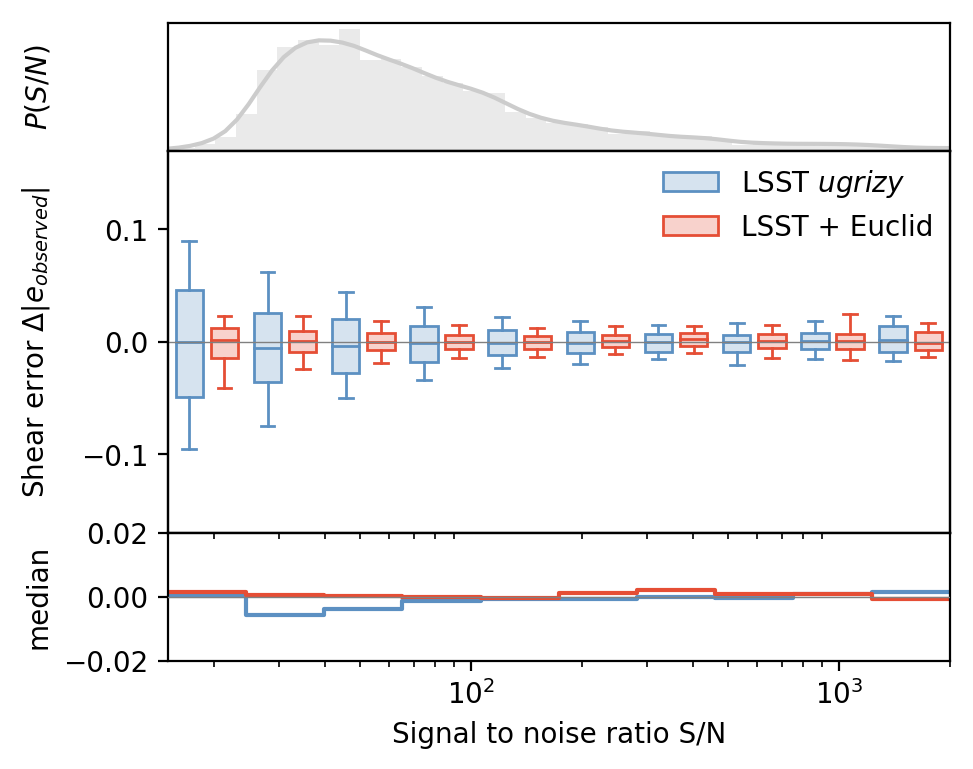

In [77]:
fig, median_shear_2, q1_shear_2, q3_shear_2, whislo_shear_2, whishi_shear_2 = boxplot_func(df_plot, 
              x = 'SNR', y = 'e_obs_error', z = 'exp',
              xlim = (15, 2000),
              ylim = (-0.17, 0.17), 
              ylim2 = (-0.02, 0.02), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |e_{observed}|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/e_vae_snr_2.pdf')

19811
[1 2]
0 1
1 2


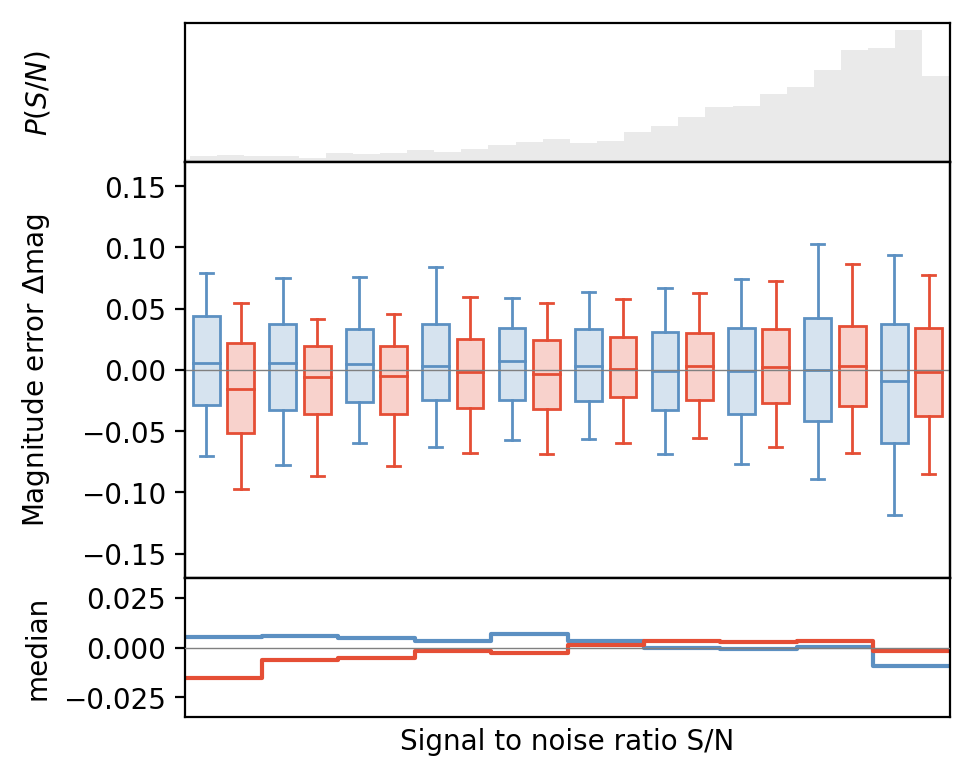

In [43]:
    fig, median_mag_2, q1_mag_2, q3_mag_2, whislo_mag_2, whishi_mag_2 = boxplot_func(df_plot, 
              x = 'mag_in', y = 'delta_mag', z = 'exp',
              xlim = (23, 27.5),
              ylim = (-0.17, 0.17), 
              ylim2 = (-0.035, 0.035), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

fig.savefig('figures_v2/mag_mag_vae_3.pdf')

19811
[1 2]
0 1
1 2


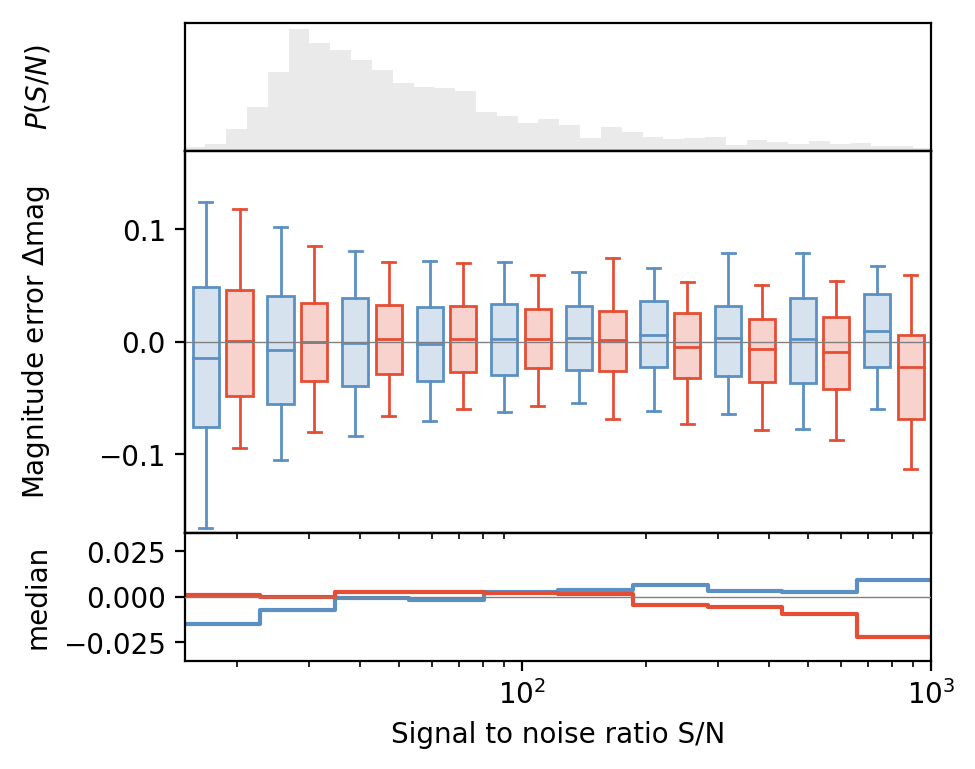

In [42]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, 
              x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (15, 1000),
              ylim = (-0.17, 0.17), 
              ylim2 = (-0.035, 0.035), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

fig.savefig('figures_v2/mag_snr_vae_3.pdf')

old plot

19817
[1 2]
0 1
1 2


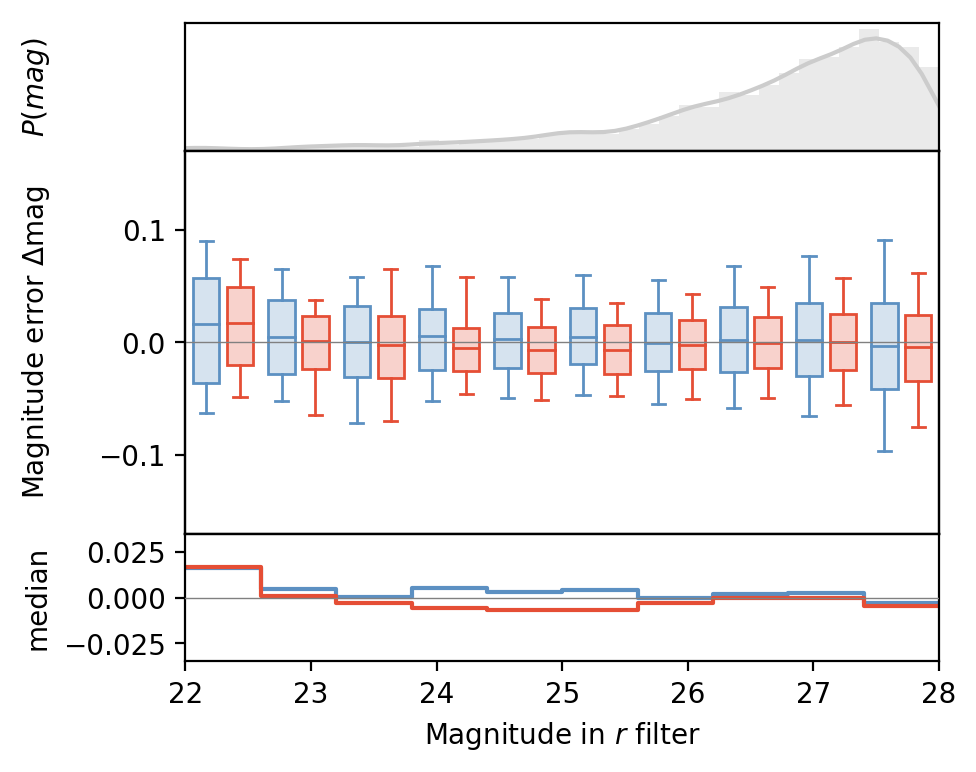

In [78]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot_func(df_plot, 
              x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (22, 28),
              ylim = (-0.17, 0.17),
              ylim2 = (-0.035, 0.035),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Magnitude in $r$ filter', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/mag_mag_vae_3.pdf')

In [29]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = np.abs(median_shear)
df_stat['q1_shear'] = np.abs(q1_shear)
df_stat['q3_shear'] = np.abs(q3_shear)
df_stat['whislo_shear'] = np.abs(whislo_shear)
df_stat['whishi_shear'] = np.abs(whishi_shear)
df_stat['median_mag'] = np.abs(median_mag)
df_stat['q1_mag'] = np.abs(q1_mag)
df_stat['q3_mag'] = np.abs(q3_mag)
df_stat['whislo_mag'] = np.abs(whislo_mag)
df_stat['whishi_mag'] = np.abs(whishi_mag)
df_stat['stats_names'] = ['LSST']*10 + ['LSST Euclid']*10

x = 10

In [62]:
x = 10 # for the first x bins

In [63]:
df_stat

,median_shear,q1_shear,q3_shear,whislo_shear,whishi_shear,median_mag,q1_mag,q3_mag,whislo_mag,whishi_mag,stats_names
0,0.004579,0.104476,0.081183,0.216947,0.212568,0.014688,0.075772,0.048992,0.165711,0.124865,LSST
1,0.022792,0.128520,0.061254,0.267730,0.160652,0.007431,0.055491,0.041208,0.104829,0.102588,LSST
2,0.011052,0.087773,0.046247,0.212607,0.124626,0.000558,0.039092,0.038887,0.083451,0.080745,LSST
3,0.004295,0.047830,0.032572,0.127507,0.087592,0.001528,0.035005,0.031044,0.069940,0.071645,LSST
4,0.003648,0.032469,0.021907,0.100712,0.062326,0.002660,0.029192,0.033344,0.062079,0.071288,LSST
5,0.002905,0.023603,0.016065,0.067800,0.046354,0.003812,0.025168,0.032265,0.054489,0.062188,LSST
6,0.000658,0.014589,0.014924,0.048438,0.051757,0.006310,0.022173,0.036696,0.061713,0.066021,LSST
7,0.000595,0.010664,0.018913,0.029271,0.050695,0.003127,0.030228,0.032044,0.063971,0.079177,LSST
8,0.000537,0.008661,0.013829,0.030174,0.078183,0.002580,0.036454,0.038953,0.077573,0.079452,LSST
9,0.001333,0.009555,0.015965,0.019882,0.070512,0.009280,0.022335,0.042279,0.059339,0.067637,LSST


In [64]:
param = 'median_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.005239382567268072, 0.004107478169898862, nan]
improvement between each exp: [1.2755716160987123, nan]


In [65]:
param = 'q1_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.04681409682481458, 0.014540351125629014, nan]
improvement between each exp: [3.219598785499714, nan]


In [66]:
param = 'q3_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.03228578070345052, 0.035582130219984374, nan]
improvement between each exp: [0.9073594105761973, nan]


In [67]:
param = 'whislo_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.11210667405661459, 0.0438889209904926, nan]
improvement between each exp: [2.5543274139936045, nan]


In [68]:
param = 'whishi_shear'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.09452648240481572, 0.10825622555743106, nan]
improvement between each exp: [0.8731736389115878, nan]


In [69]:
param = 'median_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.005197449106237428, 0.00522542481893975, nan]
improvement between each exp: [0.9946462319004337, nan]


In [70]:
param = 'q1_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.03709116057929573, 0.03650556938424392, nan]
improvement between each exp: [1.0160411467326558, nan]


In [71]:
param = 'q3_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.03757126844632984, 0.02764753443340818, nan]
improvement between each exp: [1.358937395912245, nan]


In [72]:
param = 'whislo_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.08030948094582194, 0.07770806893107682, nan]
improvement between each exp: [1.0334767296437701, nan]


In [73]:
param = 'whishi_mag'
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.08056040296296559, 0.06950827363623446, nan]
improvement between each exp: [1.1590045148376362, nan]


## Shear Bias 

As function of SNR

In [46]:
df_bias = pd.DataFrame()
param = 'SNR'
#df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & (df_lsst_euclid['e2_out']<=1.)]

bins = np.geomspace(30, 3000, 10)

for k in range (2):
    slope = []
    intercept = []
    std_err = []
    bins_list = []

    bining_temp = 10
    mask = ~np.isnan(df_lsst['e_in']) & ~np.isnan(df_lsst['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst[(df_lsst['e1_out']<=1.) & 
                          (df_lsst['e2_out']<=1.) &
                          (df_lsst['e_out']<=1.) & 
                          (df_lsst['e_out']>=0.) &
                          (bining_temp <= df_lsst[param]) &
                          (df_lsst[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)#-(bins[0]/2)
        bining_temp = bining

    bining_temp = 10
    mask = ~np.isnan(df_lsst_euclid['e_in']) & ~np.isnan(df_lsst_euclid['e_out'])
    for i, bining in enumerate (bins):
        df_test = df_lsst_euclid[(df_lsst_euclid['e1_out']<=1.) & 
                                 (df_lsst_euclid['e2_out']<=1.) &
                                 (df_lsst_euclid['e_out']<=1.) & 
                                 (df_lsst_euclid['e_out']>=0.) &
                                 (bining_temp <= df_lsst_euclid[param]) &
                                 (df_lsst_euclid[param]<= bining)]
        slope.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[0]-1)
        intercept.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[1])
        std_err.append(stats.linregress(df_test['e'+str(k+1)+'_in'][mask], df_test['e'+str(k+1)+'_out'][mask])[4])
        bins_list.append(bining)#-(bins[0]/2)
        bining_temp = bining

    df_bias['slope_e'+str(k+1)] = np.array(slope)
    df_bias['intercept_e'+str(k+1)] = np.array(intercept)
    df_bias['std_err_e'+str(k+1)] = np.array(std_err)

In [47]:
list_mid_bins = []
idx_temp = 10
for i, idx in enumerate (bins_list):
    if i == 10:
        idx_temp = 10
    list_mid_bins.append(idx - (idx - idx_temp)/2)
    idx_temp = idx

In [48]:
list_mid_bins, bins_list, 

([20.0,
  40.02150805800087,
  66.75989909110773,
  111.36222353729855,
  185.76338490636067,
  309.87200215440146,
  516.897653257015,
  862.2372530754765,
  1438.2984250491058,
  2399.2263754784126,
  20.0,
  40.02150805800087,
  66.75989909110773,
  111.36222353729855,
  185.76338490636067,
  309.87200215440146,
  516.897653257015,
  862.2372530754765,
  1438.2984250491058,
  2399.2263754784126],
 [29.999999999999996,
  50.043016116001745,
  83.47678206621372,
  139.24766500838336,
  232.27910480433795,
  387.46489950446494,
  646.330407009565,
  1078.144099141388,
  1798.4527509568234,
  3000.0000000000014,
  29.999999999999996,
  50.043016116001745,
  83.47678206621372,
  139.24766500838336,
  232.27910480433795,
  387.46489950446494,
  646.330407009565,
  1078.144099141388,
  1798.4527509568234,
  3000.0000000000014])

In [49]:
df_bias['Experience'] = len(bins)*['LSST'] + len(bins)*['LSST+Euclid']
df_bias['bins_list'] = list_mid_bins
df_bias['mean_g'] = np.mean([df_bias['slope_e1'],df_bias['slope_e2']], axis = 0)
df_bias['mean_stderr'] = np.mean([df_bias['std_err_e1'],df_bias['std_err_e2']], axis = 0)

In [50]:
df_bias

,slope_e1,intercept_e1,std_err_e1,slope_e2,intercept_e2,std_err_e2,Experience,bins_list,mean_g,mean_stderr
0,-0.116480,0.000077,0.006417,-0.121544,0.003436,0.006773,LSST,20.000000,-0.119012,0.006595
1,-0.112146,-0.002609,0.004895,-0.111593,0.002803,0.005109,LSST,40.021508,-0.111870,0.005002
2,-0.064557,-0.000798,0.004175,-0.070514,0.000662,0.003974,LSST,66.759899,-0.067535,0.004074
3,-0.052540,-0.001557,0.003422,-0.055240,0.000017,0.003547,LSST,111.362224,-0.053890,0.003484
4,-0.022863,-0.002522,0.003998,-0.016510,0.001979,0.004259,LSST,185.763385,-0.019687,0.004128
5,-0.003534,-0.000714,0.003185,-0.005602,0.002267,0.003340,LSST,309.872002,-0.004568,0.003262
6,0.002632,-0.000366,0.003264,0.011782,0.002860,0.003889,LSST,516.897653,0.007207,0.003576
7,0.028325,0.000152,0.007507,0.019040,0.004275,0.005255,LSST,862.237253,0.023683,0.006381
8,0.041847,0.003106,0.009758,0.026100,-0.002526,0.011006,LSST,1438.298425,0.033973,0.010382
9,0.000855,-0.005864,0.030557,-0.016190,0.001867,0.025982,LSST,2399.226375,-0.007668,0.028269


["['LSST $|g_1|$', 'LSST+Euclid $|g_1|$']", 'Experience', 'LSST', 'LSST+Euclid']
["['LSST $|g_2|$', 'LSST+Euclid $|g_2|$']", 'Experience', 'LSST', 'LSST+Euclid']
['Experience', 'LSST', 'LSST+Euclid']


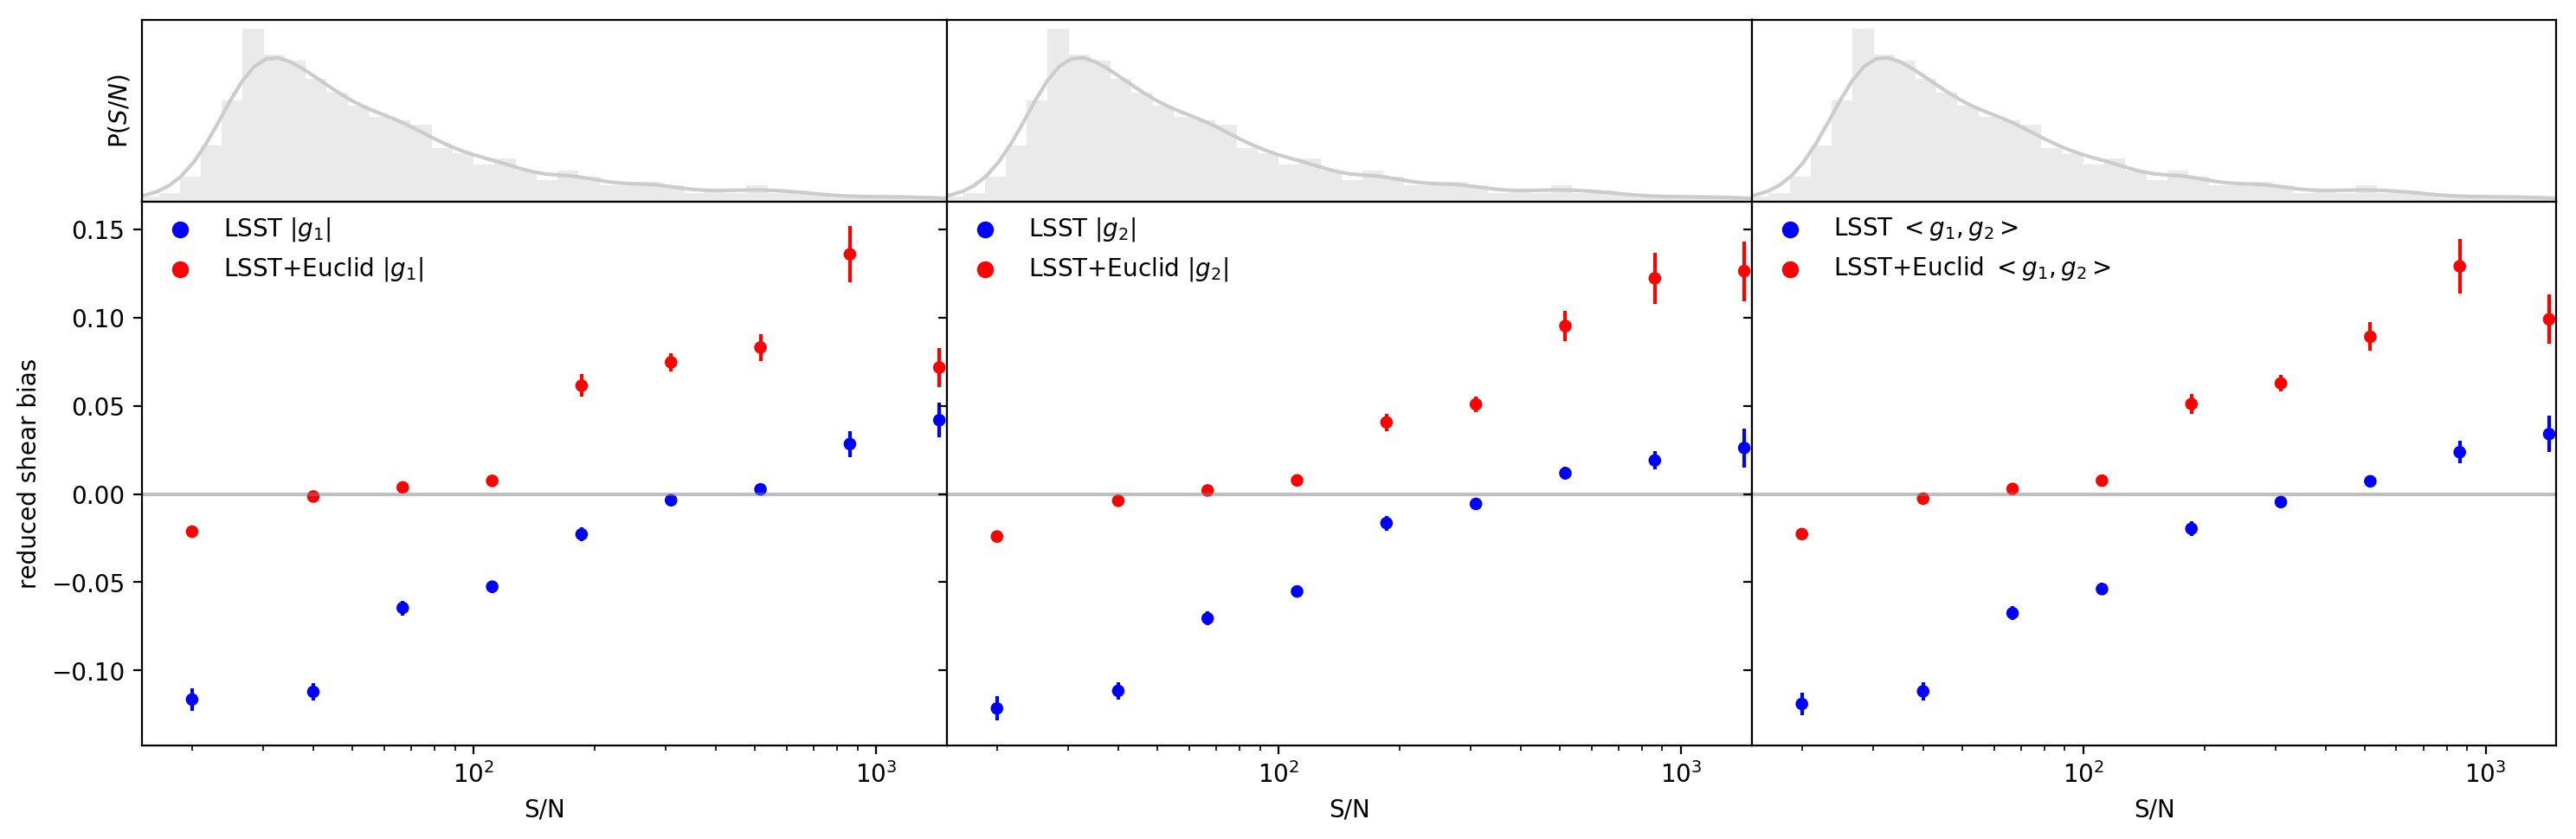

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(15,5),sharey='row', gridspec_kw={'height_ratios': [1, 3]})

palette_lsst = ['blue']
palette_lsst_euclid = ['red']

xlim = (15,1500)
xscale = 'log'

for i in range (3):
    sns.distplot(np.log10(df_lsst[param]), ax=axes[0,i], color='0.8')
    axes[0,i].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
axes[0,0].set_ylabel('P($S/N$)')
axes[0,0].set_yticks([])

for k in range (2):
    handles = []
    legend = []

    axis = axes[1,k]
    ax = sns.scatterplot(x="bins_list",
                  y="slope_e"+str(k+1), 
                  hue="Experience",
                  data=df_bias, 
                  markers = '.',
                  palette = [palette_lsst[0], palette_lsst_euclid[0]],
                  label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
                  ax = axis)
    print(ax.get_legend_handles_labels()[1])

    handles.append(ax.get_legend_handles_labels()[0][2])
    handles.append(ax.get_legend_handles_labels()[0][3])
    legend.append('LSST $|g_'+str(k+1)+'|$')
    legend.append('LSST+Euclid $|g_'+str(k+1)+'|$')
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []

    for i, idx in enumerate (df_bias['bins_list']):
        x_coords.append(idx)
        y_coords.append(df_bias["slope_e"+str(k+1)][i])

    colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/2) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/2)

    axis.errorbar(x_coords, 
                 y_coords, 
                 yerr=df_bias['std_err_e'+str(k+1)],
                 ecolor=colors,
                 fmt=' ')


    axis.legend(handles, legend, frameon=False, loc ='upper left', borderpad = 0.1, fontsize = 10)
    axis.set_xlabel('S/N')
    axis.set_ylabel('reduced shear bias')
    axis.axhline(0,color = 'grey', alpha = 0.5)
    axis.set_xscale(xscale)
    axis.set_xlim(xlim)

 

handles = []
legend = []

axis = axes[1,2]
ax = sns.scatterplot(x="bins_list",
              y="mean_g", 
              hue="Experience",
              data=df_bias, 
              markers = '.',
              palette = [palette_lsst[0], palette_lsst_euclid[0]],
              #label = ['LSST $|g_'+str(k+1)+'|$','LSST+Euclid $|g_'+str(k+1)+'|$'],
              ax = axis)
print(ax.get_legend_handles_labels()[1])

handles.append(ax.get_legend_handles_labels()[0][1])
handles.append(ax.get_legend_handles_labels()[0][2])
legend.append('LSST $<g_1, g_2>$')
legend.append('LSST+Euclid $<g_1, g_2>$')
# Find the x,y coordinates for each point
x_coords = []
y_coords = []

for i, idx in enumerate (df_bias['bins_list']):
    x_coords.append(idx)
    y_coords.append(df_bias["mean_g"][i])

colors = [palette_lsst[0]]*int(len(df_bias['bins_list'])/2) + [palette_lsst_euclid[0]]*int(len(df_bias['bins_list'])/2)

axis.errorbar(x_coords, 
             y_coords, 
             yerr=df_bias['mean_stderr'],
             ecolor=colors,
             fmt=' ')


axis.legend(handles, legend, frameon=False, loc ='upper left', borderpad = 0.1, fontsize = 10)#, colors = ['steelblue','coral','blue','red'])
axis.set_xlabel('S/N')
axis.axhline(0, color = 'grey', alpha = 0.5)
axis.set_xscale(xscale)
axis.set_xlim(xlim)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)